In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [3]:
# Define the path to the input dataset
input_dir = '/kaggle/input/cotton-leaf-dataset/Augmented Dataset/Augmented Dataset'
working_dir = '/kaggle/working/cotton-leaf-dataset-split'

# Create directories for train, validation, and test datasets
train_dir = os.path.join(working_dir, 'train')
val_dir = os.path.join(working_dir, 'val')
test_dir = os.path.join(working_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split data into train, val, and test
classes = os.listdir(input_dir)
for class_name in classes:
    class_path = os.path.join(input_dir, class_name)
    if os.path.isdir(class_path):
        all_files = os.listdir(class_path)
        train_files, temp_files = train_test_split(all_files, test_size=0.3, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=2/3, random_state=42)
        
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        for file in train_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(train_dir, class_name, file))
        for file in val_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(val_dir, class_name, file))
        for file in test_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(test_dir, class_name, file))

print("Data has been split and saved in the working directory.")

# Define hyperparameters
initial_lr = 0.0001
batch_size = 32
epochs = 50

Data has been split and saved in the working directory.


In [4]:
# Set up data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(224, 224),
                                                batch_size=batch_size,
                                                class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)


Found 4900 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
Found 1400 images belonging to 7 classes.


In [5]:
# Define the DenseNet121 model
base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Define callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732816631.279053     125 service.cc:145] XLA service 0x7cf654003580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732816631.279125     125 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/154 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.1172 - loss: 2.6424    

I0000 00:00:1732816644.371659     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


154/154 ━━━━━━━━━━━━━━━━━━━━ 78s 346ms/step - accuracy: 0.2910 - loss: 1.9805 - val_accuracy: 0.7200 - val_loss: 0.9902 - learning_rate: 1.0000e-04
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 27s 169ms/step - accuracy: 0.6177 - loss: 1.0762 - val_accuracy: 0.7957 - val_loss: 0.7214 - learning_rate: 1.0000e-04
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 27s 169ms/step - accuracy: 0.7223 - loss: 0.8344 - val_accuracy: 0.8414 - val_loss: 0.5744 - learning_rate: 1.0000e-04
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 26s 165ms/step - accuracy: 0.7766 - loss: 0.6922 - val_accuracy: 0.8657 - val_loss: 0.4870 - learning_rate: 1.0000e-04
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 27s 169ms/step - accuracy: 0.8071 - loss: 0.5889 - val_accuracy: 0.8700 - val_loss: 0.4272 - learning_rate: 1.0000e-04
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 27s 168ms/step - accuracy: 0.8222 - loss: 0.5384 - val_accuracy: 0.8757 - val_loss: 0.3874 - learning_rate: 1.0000e-04
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 27s 165ms/step - 

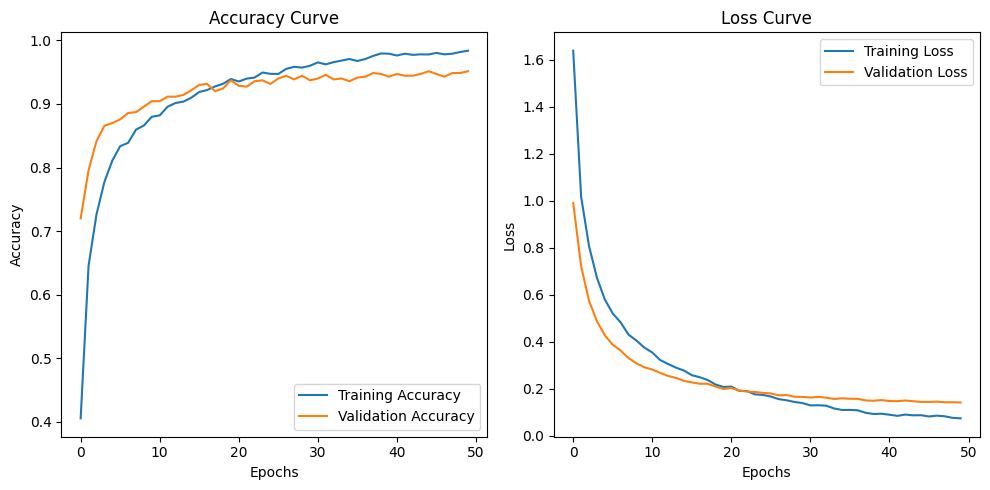

44/44 - 15s - 347ms/step - accuracy: 0.9464 - loss: 0.1489
Test Accuracy: 0.9464285969734192
Test Loss: 0.14887915551662445
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 314ms/step


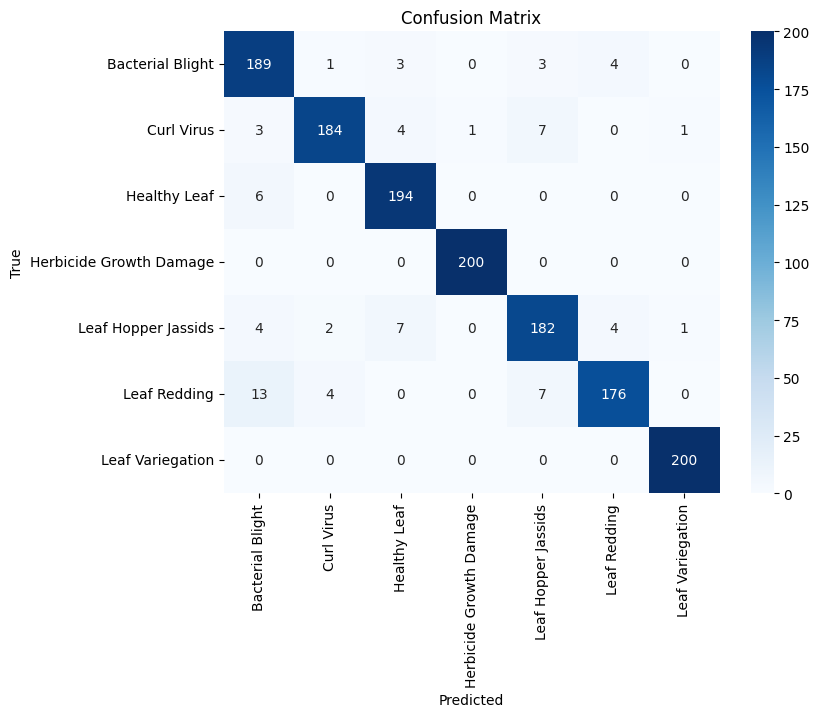

Overall Accuracy: 94.64%
Overall Precision: 94.73%
Overall Recall: 94.64%
Overall F1 Score: 94.64%

Classification Report:
                          precision    recall  f1-score   support

       Bacterial Blight       0.88      0.94      0.91       200
             Curl Virus       0.96      0.92      0.94       200
           Healthy Leaf       0.93      0.97      0.95       200
Herbicide Growth Damage       1.00      1.00      1.00       200
    Leaf Hopper Jassids       0.91      0.91      0.91       200
           Leaf Redding       0.96      0.88      0.92       200
       Leaf Variegation       0.99      1.00      1.00       200

               accuracy                           0.95      1400
              macro avg       0.95      0.95      0.95      1400
           weighted avg       0.95      0.95      0.95      1400



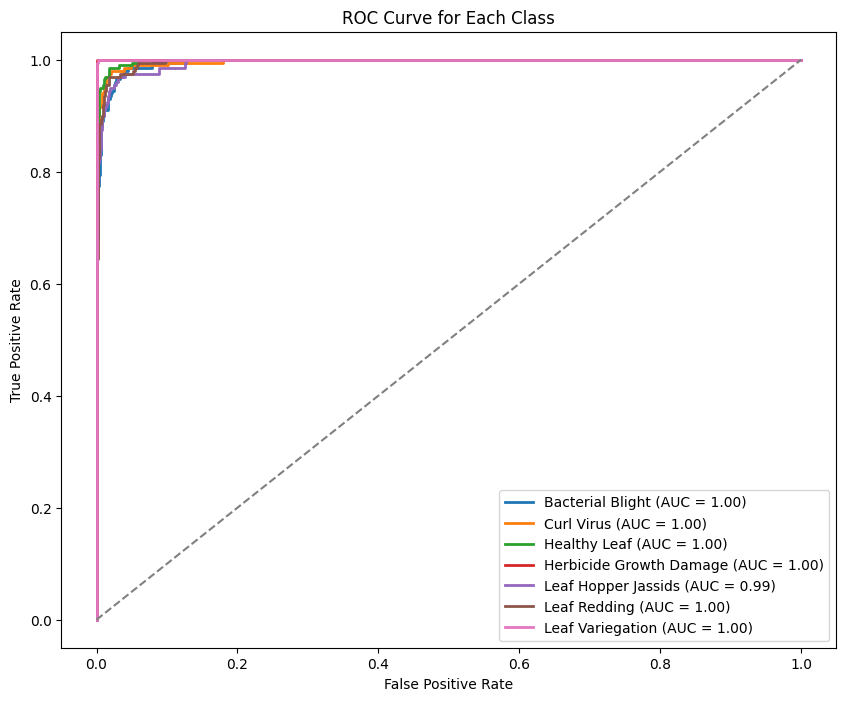

In [7]:
# Plot accuracy and loss curves
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# Predictions and evaluation metrics
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print(f"Overall Precision: {precision * 100:.2f}%")
print(f"Overall Recall: {recall * 100:.2f}%")
print(f"Overall F1 Score: {f1 * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# ROC Curve
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)
n_classes = y_true_bin.shape[1]
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()